# Silo notebook example

In this example, a rule based controller is used to control the model "SiloFanFCU-v0". At first we import the controller:

In [1]:
from energym.examples.Controller import SiloController

Next, we import Energym and create the simulation environment by specifying the model, a weather file and the number of simulation days.

In [2]:
import energym

weather = "GRC_A_Athens" 
env = energym.make("SiloFanFCU-v0", weather=weather, simulation_days=30)

[OK] fmi2Instantiate: The Resource location of FMU with instance name %s is %s.

[WARNING] fmi2Instantiate: Argument loggingOn is set to %d
. This is not supported. loggingOn will default to '0'.

[OK] The current working directory is %s

[OK] fmi2Instantiate: Path to fmuUnzipLocation is not %s.

[OK] fmi2Instantiate: Path to fmuUnzipLocation is not %s.

[OK] fmi2Instantiate: Path to fmuUnzipLocation is not %s.

[OK] fmi2Instantiate: Path to fmuUnzipLocation %s

[OK] fmi2Instantiate: Path to fmuResourceLocation %s

[OK] Command executes to copy content of resources folder: %s

[OK] fmi2Instantiate: Path to model description file is %s.

[OK] fmi2Instantiate: The FMU modelIdentifier is %s.

[OK] fmi2Instantiate: The FMU modelGUID is %s.

[OK] fmi2Instantiate: Slave %s is instantiated.

[OK] fmi2Instantiate: Instantiation of %s succeded.

[OK] fmi2EnterInitializationMode: The sockfd is %d.

[OK] fmi2EnterInitializationMode: The port number is %d.

[OK] fmi2EnterInitializationMode: This h

The control inputs can be inspected using the `get_inputs_names()` method and to construct a controller, we pass the list of inputs and further parameters. This controller determines inputs to get close to the temperature setpoints and uses fixed setpoints during the night.

In [3]:
inputs = env.get_inputs_names()
print(inputs)
controller = SiloController(control_list=inputs, lower_tol=0.3, upper_tol=0.8, nighttime_setback=True, nighttime_start=17, nighttime_end=6, nighttime_temp=18)

['Bd_Fl_AHU1_sp', 'Bd_Fl_AHU2_sp', 'Bd_T_AHU1_sp', 'Bd_T_AHU2_sp', 'Z02_T_Thermostat_sp', 'Z03_T_Thermostat_sp', 'Z04_T_Thermostat_sp', 'Z05_T_Thermostat_sp', 'Z08_T_Thermostat_sp', 'Z09_T_Thermostat_sp', 'Z10_T_Thermostat_sp', 'Z11_T_Thermostat_sp']


To run the simulation, a number of steps is specified (here 96 steps per day for 10 days) and the obtained control inputs are passed to the simulation model with the `step()` method. To generate some plots later on, we save all the inputs and outputs in lists.

In [4]:
steps = 96*10
out_list = []
outputs = env.step(env.sample_random_action())
controls = []
hour = 0
for _ in range(steps):
    control = controller.get_control(outputs, 22, hour)
    control = {p:control[p] for p in control if p in inputs}
    controls +=[ {p:control[p][0] for p in control} ]
    outputs = env.step(control)
    _,hour,_,_ = env.get_date()
    out_list.append(outputs)

Since the inputs and outputs are given as dictionaries and are collected in lists, we can simply load them as a pandas.DataFrame.

In [5]:
import pandas as pd
out_df = pd.DataFrame(out_list)
cmd_df = pd.DataFrame(controls)

To generate plots, we can directly get the data from the DataFrames, by using the key names. Displayed are the zone temperatures and the setpoints determined by the controller for zone 2 as well as the flow setpoint, the external temperature, and the total power demand.

<IPython.core.display.Javascript object>


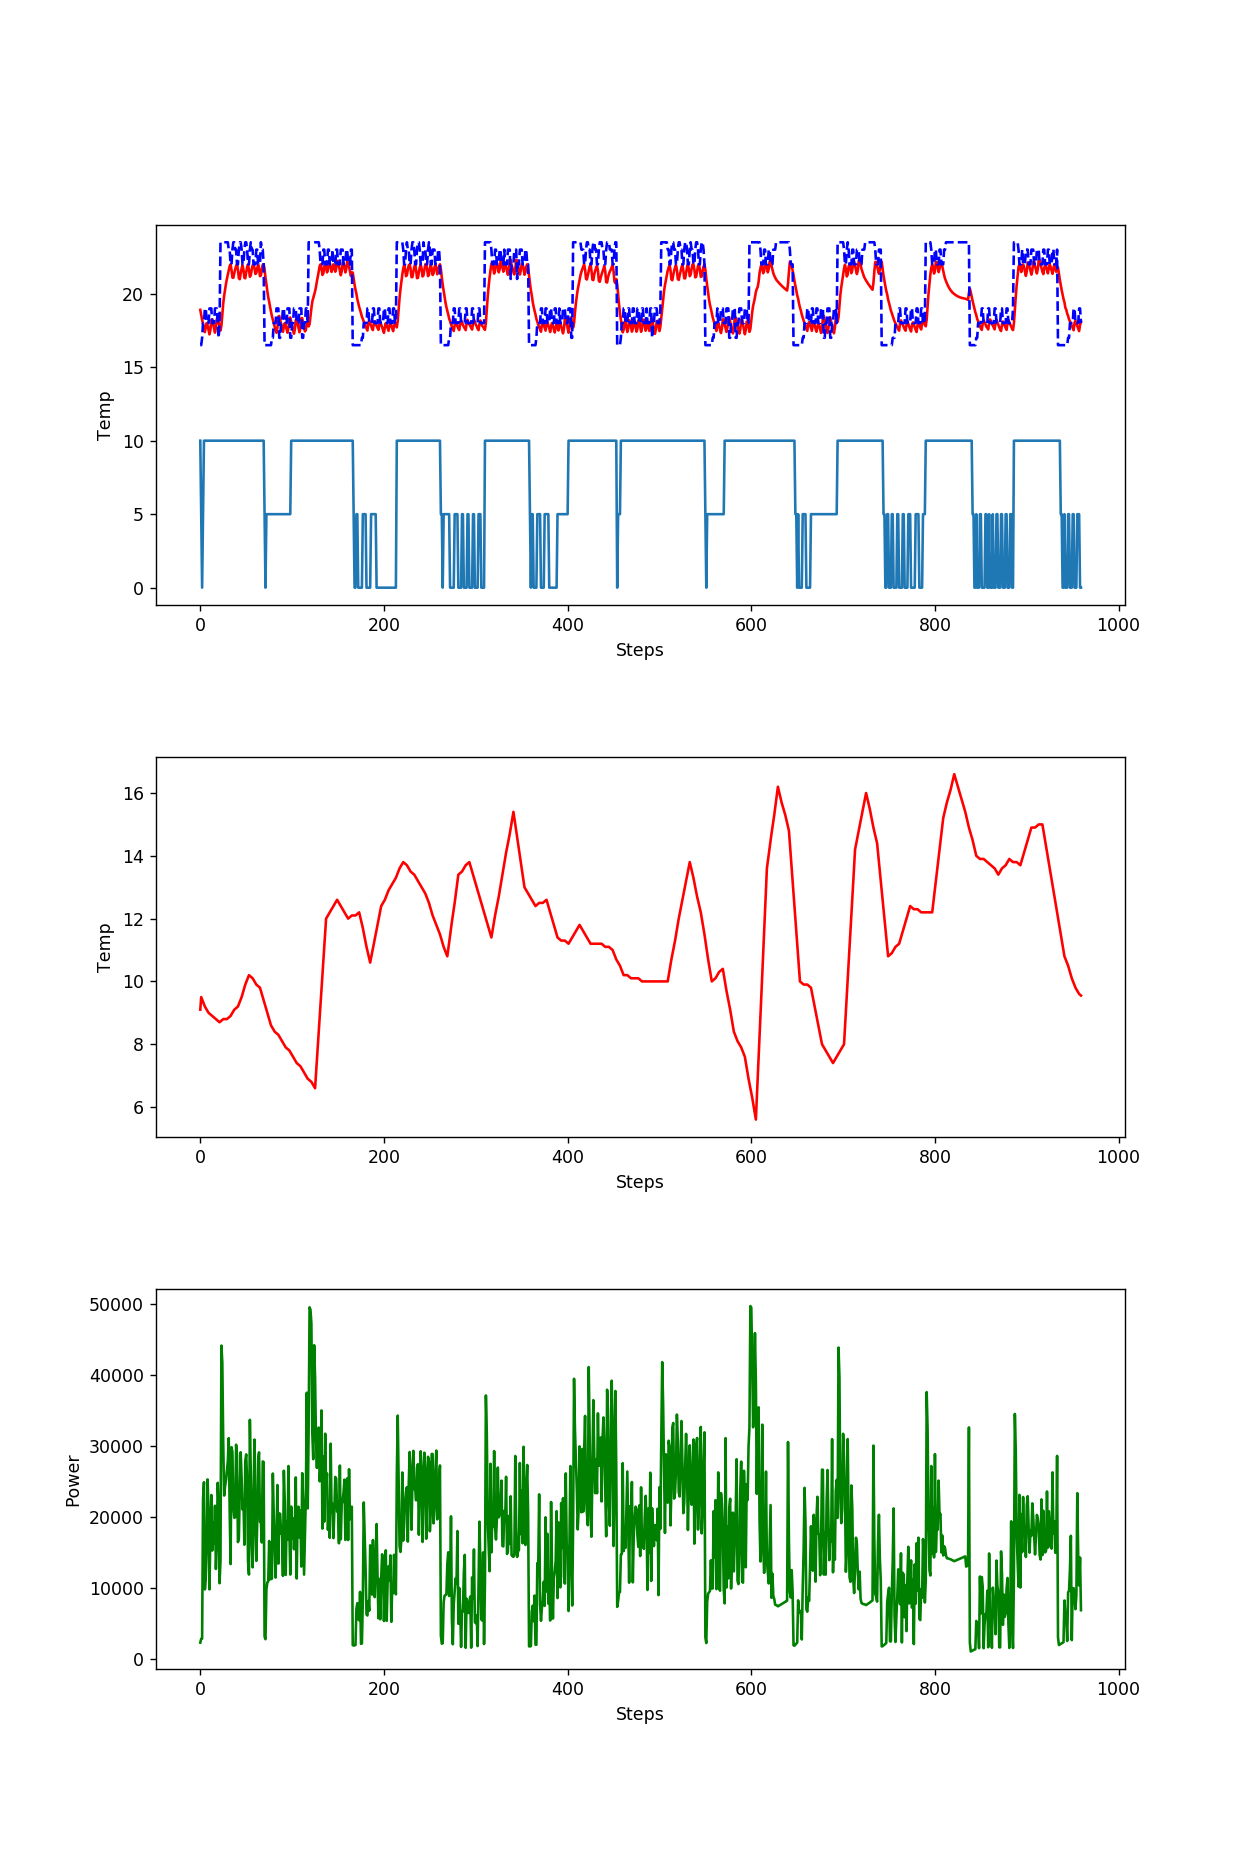

In [6]:
import matplotlib.pyplot as plt
%matplotlib notebook

f, (ax1,ax2,ax3) = plt.subplots(3,figsize=(10,15))#


ax1.plot(out_df['Z02_T'], 'r')
ax1.plot(out_df['Z02_T_Thermostat_sp_out'], 'b--')
ax1.plot(cmd_df['Bd_Fl_AHU1_sp'])
ax1.set_ylabel('Temp')
ax1.set_xlabel('Steps')

ax2.plot(out_df['Ext_T'], 'r')
ax2.set_ylabel('Temp')
ax2.set_xlabel('Steps')

ax3.plot(out_df['Fa_Pw_All'], 'g')
ax3.set_ylabel('Power')
ax3.set_xlabel('Steps')

plt.subplots_adjust(hspace=0.4)

plt.show()

To end the simulation, the `close()` method is called. It deletes files that were produced during the simulation and stores some information about the simulation in the *runs* folder.

In [7]:
env.close()

[OK] fmi2Terminate: fmiFreeInstanceSlave must be called to free the FMU instance.

[OK] fmi2FreeInstance: The function fmi2FreeInstance of instance %s is executed.

[OK] freeInstanceResources: %s will be freed.

